## Regression Coefficients are affected by regularisation

As I mentioned previously, regularisation applies a penalty on the coefficients, in order to reduce their influence and create models that generalise better. This is very good to improve  model performance. However, it masks the true relationship between the predictor X and the outcome Y. Let's explore why.

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from helper_fe_v2 import (
            get_full_datapath_nm,
            read_df_from_file,
            check_module_members,
            gen_correlation,
            do_bkwd_fwd_selection,
            yaml_path,
            read_yaml_conf,
            run_randomForestClassifier,
            run_logistic,
            run_randomForestRegressor
)

In [3]:
config = read_yaml_conf(yaml_path())
print ("yaml_ conf ", config ) 

yaml_ conf  {'write_file': True, 'base_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments', 'full_config_file': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\py-projects.yaml', 'cur_kaggle_expt': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\fe-recipes', 'files': {'test_data_set2': 'fselect_dataset_2.csv', 'housing_data': 'housing_prices_train.csv', 'test_data_set1': 'fselect_dataset_1.csv', 'titanic_data': 'fe-cookbook-titanic.csv', 'comp_eda_file': 'none.csv'}, 'project_parms': {'use_mlxtnd': 'False'}, 'process_eda': {'main_file': 'fselect_dataset_2.csv', 'compre_file': 'none.csv', 'pairwise_analysis': 'on', 'show_html': 'False'}, 'RandomForestConfig': {'n_estimators': 200, 'rand_state': 39, 'max_depth': 4}}


In [4]:
data = read_df_from_file ( config['files']['test_data_set2'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\fselect_dataset_2.csv


(50000, 109)

In [5]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


In [6]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

# we train 4 different models, decreasing the amount
# of regularisation (that is, increasing C)

# here we will store the coefficients of the variables
# fitted for each different model
coefs_df = []

# we train 4 different models with regularization
penalties = [0.00005, 0.0005, 0.005, 0.05, 0.5]

for c in penalties:   
    
    logit = LogisticRegression(C=c, penalty='l2', random_state=10, max_iter=300)
    logit.fit(scaler.transform(X_train), y_train)
    
    # store the coefficients of the variables in a list
    coefs_df.append(pd.Series(logit.coef_.ravel()))

In [8]:
# now I create a dataframe with the coefficients for all
# the variables for the 4 different logistic regression models

coefs = pd.concat(coefs_df, axis=1)
coefs.columns = penalties
coefs.index = X_train.columns
coefs.head()

,0.00005,0.00050,0.00500,0.05000,0.50000
var_1,0.002746,0.005288,0.007366,0.011095,0.011698
var_2,-0.005650,-0.010763,-0.012708,-0.012865,-0.013253
var_3,0.000971,-0.002668,0.007178,0.061188,0.102295
var_4,0.001327,-0.002046,0.001087,0.020369,0.026260
var_5,0.002923,0.008070,0.025891,0.039422,0.042930


In [9]:
# apply log scale to the penalties (simplifies comparison)

coefs.columns = np.log(penalties)
coefs.head()

,-9.903488,-7.600902,-5.298317,-2.995732,-0.693147
var_1,0.002746,0.005288,0.007366,0.011095,0.011698
var_2,-0.005650,-0.010763,-0.012708,-0.012865,-0.013253
var_3,0.000971,-0.002668,0.007178,0.061188,0.102295
var_4,0.001327,-0.002046,0.001087,0.020369,0.026260
var_5,0.002923,0.008070,0.025891,0.039422,0.042930


Text(0.5, 1.0, 'Coefficient value vs penalty. Each line corresponds to one variable')

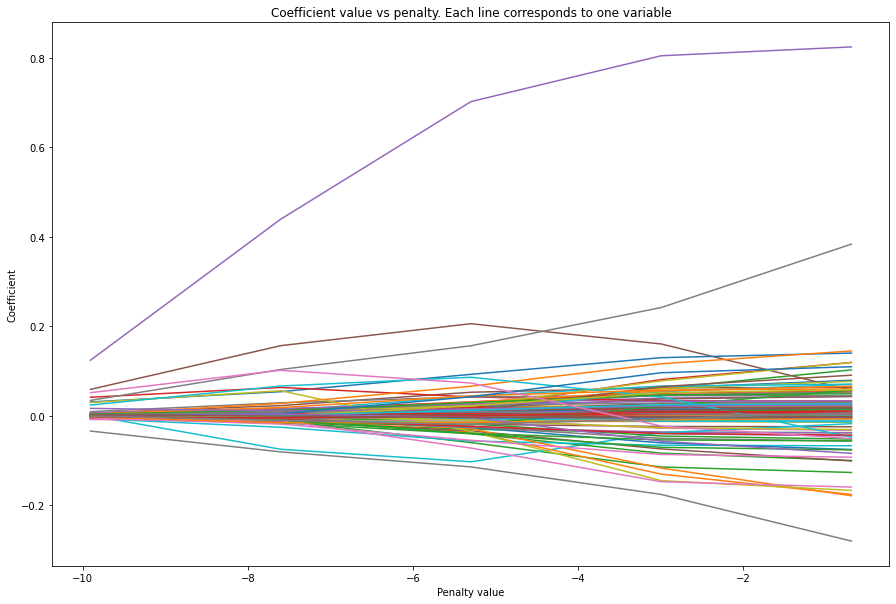

In [10]:
# plot the change in coefficients with the penalty
coefs.T.plot(figsize=(15,10), legend=False)
plt.xlabel('Penalty value')
plt.ylabel('Coefficient')
plt.title('Coefficient value vs penalty. Each line corresponds to one variable')

Text(0.5, 1.0, 'Coefficient value vs penalty')

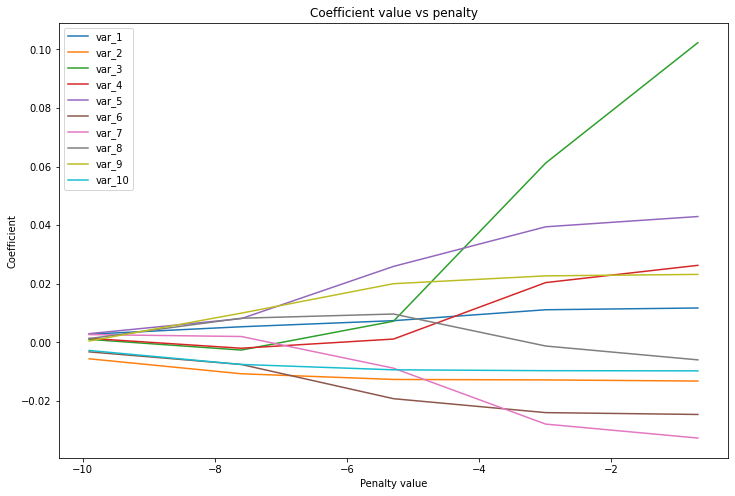

In [11]:
# now I will plot only the first 10 features for better
# visualisation

temp = coefs.head(10)
temp = temp.T
temp.plot(figsize=(12,8))
plt.xlabel('Penalty value')
plt.ylabel('Coefficient')
plt.title('Coefficient value vs penalty')

We can see that the relation among the coefficients is complex. Some features show bigger coefficients than others without regularisation, but when the penalty increases this relationship changes.

Some other features are very important (show big coefficients) without regularisation, but with regularization their importance is similar to that of other features.

While this is not crucial to selet features, this is actually quite important when our aim is to understand the true relationship of a variable with the target. Or in other words, when we need to interpret and fully understand the outcome of the Linear Regression.

Text(0.5, 1.0, 'Coefficient value vs penalty')

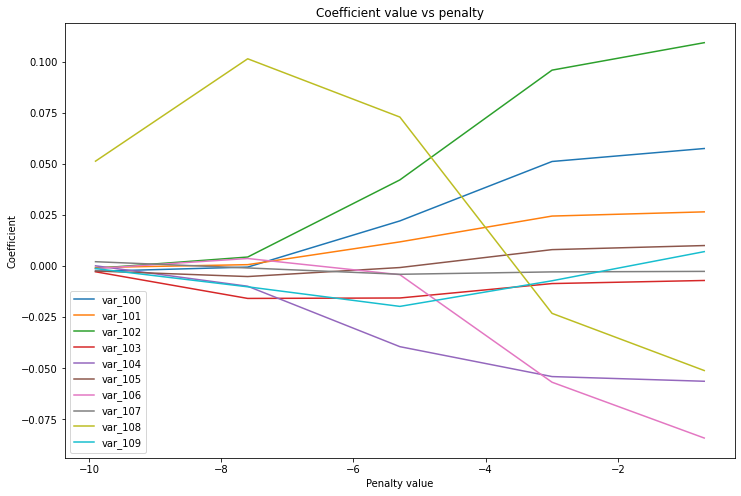

In [12]:
# plot another 10 features for visualisation
temp = coefs.tail(10)
temp = temp.T
temp.plot(figsize=(12,8))
plt.xlabel('Penalty value')
plt.ylabel('Coefficient')
plt.title('Coefficient value vs penalty')

Same as before, the relationship between features, as inferred from the coefficients, changes depending on the level of regularisation.


## Feature selection with linear models, review
### Putting it all together

In [13]:
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

In [14]:
config = read_yaml_conf(yaml_path())
print ("yaml_ conf ", config ) 

yaml_ conf  {'write_file': True, 'base_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments', 'full_config_file': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\py-projects.yaml', 'cur_kaggle_expt': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\fe-recipes', 'files': {'test_data_set2': 'fselect_dataset_2.csv', 'housing_data': 'housing_prices_train.csv', 'test_data_set1': 'fselect_dataset_1.csv', 'titanic_data': 'fe-cookbook-titanic.csv', 'comp_eda_file': 'none.csv'}, 'project_parms': {'use_mlxtnd': 'False'}, 'process_eda': {'main_file': 'fselect_dataset_2.csv', 'compre_file': 'none.csv', 'pairwise_analysis': 'on', 'show_html': 'False'}, 'RandomForestConfig': {'n_estimators': 200, 'rand_state': 39, 'max_depth': 4}}


In [15]:
data = read_df_from_file ( config['files']['test_data_set1'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\fselect_dataset_1.csv


(50000, 301)

In [16]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

In [17]:
# I keep a copy of the dataset with all the variables
# to compare the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

In [18]:
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 266), (15000, 266))

In [19]:
# find features with low variance
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train)  

# how many not quasi-constant?
sum(sel.get_support()) 

215

In [20]:
features_to_keep = X_train.columns[sel.get_support()]

In [21]:
# remove the features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 215), (15000, 215))

In [22]:
# sklearn transformations lead to numpy arrays
# here we transform the arrays back to dataframes

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

In [23]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210


10

In [24]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 205), (15000, 205))

In [25]:
# I keep a copy of the dataset except constant, quasi-constant and duplicated variables

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

In [26]:
# remove correlated features to reduce the feature space
# remove correlated features to reduce the feature space

corr_features = gen_correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )


correlated features:  93


In [27]:
# remove correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [28]:
# keep a copy of the dataset without correlated features
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Select features by the regression coefficients

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [30]:
# we use regularisation by setting a low value of C

sel_ = SelectFromModel(
    LogisticRegression(C=0.0005, random_state=10, max_iter=1000, penalty='l2'))

sel_.fit(scaler.transform(X_train), y_train)

# select features where coefficient is above the mean
# coefficient value and parse again as dataframe
# (remember that the output of sklearn is a
# numpy array)

X_train_coef = pd.DataFrame(sel_.transform(X_train))
X_test_coef = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_coef.columns = X_train.columns[(sel_.get_support())]
X_test_coef.columns = X_train.columns[(sel_.get_support())]

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [31]:
X_train_coef.shape, X_test_coef.shape

((35000, 28), (15000, 28))

In [32]:
# original dataset - all variables

run_logistic(X_train_original,
             X_test_original,
             y_train,
             y_test,
             C=0.0005, max_iter=10000, penalty='l2' )

Train set
Logistic Regression roc-auc: 0.7844213790053062
Test set
Logistic Regression roc-auc: 0.7825685631204591


array([[0.97986057, 0.02013943],
       [0.92824298, 0.07175702],
       [0.97426556, 0.02573444],
       ...,
       [0.9802489 , 0.0197511 ],
       [0.9762766 , 0.0237234 ],
       [0.9315733 , 0.0684267 ]])

In [34]:
# filter methods - basic
run_logistic(X_train_basic_filter,
             X_test_basic_filter,
             y_train,
             y_test, C=0.0005, max_iter=10000, penalty='l2')

Train set
Logistic Regression roc-auc: 0.7841215084117658
Test set
Logistic Regression roc-auc: 0.7823687162836174


array([[0.9798478 , 0.0201522 ],
       [0.92835854, 0.07164146],
       [0.97433688, 0.02566312],
       ...,
       [0.98023894, 0.01976106],
       [0.97625635, 0.02374365],
       [0.9315169 , 0.0684831 ]])

In [35]:
# filter methods - correlation
run_logistic(X_train_corr,
             X_test_corr,
             y_train,
             y_test, C=0.0005, max_iter=10000, penalty='l2')

Train set
Logistic Regression roc-auc: 0.7775268841746482
Test set
Logistic Regression roc-auc: 0.7760748408318285


array([[0.97568901, 0.02431099],
       [0.94148652, 0.05851348],
       [0.97765874, 0.02234126],
       ...,
       [0.97605032, 0.02394968],
       [0.96663632, 0.03336368],
       [0.9426686 , 0.0573314 ]])

In [36]:
# embedded methods - Logistic regression coefficients
run_logistic(X_train_coef,
             X_test_coef,
             y_train,
             y_test, C=0.0005, max_iter=10000, penalty='l2')

Train set
Logistic Regression roc-auc: 0.7754621344319395
Test set
Logistic Regression roc-auc: 0.7719805239762513


array([[0.97577253, 0.02422747],
       [0.94129374, 0.05870626],
       [0.97344428, 0.02655572],
       ...,
       [0.97615171, 0.02384829],
       [0.96661888, 0.03338112],
       [0.94261228, 0.05738772]])

We see that a model with 28 features performs almost as well as a model trained with all the 215 variables!

**Exercise**:
Change the C in the LogisticRegression model used to select features, and see how that affects the performance of the model trained at the back of this feature selection procedure.
